In [1]:
from manim import *
import jupyter_capture_output

video_scene = " -v WARNING  --disable_caching galvani_Scene"
image_scene = f" -v WARNING --disable_caching -r {2*427},{2*240}  -s galvani_Scene"

Jupyter Capture Output v0.0.11


In [2]:
# parameters of the system
k = 1                       # proportionality between current I and magnetic field B_coil
gamma = 0.25                 # friction coefficient
delta_t = 0.1               # time increment


# force on the needle by the magnetic field of the earth (depending on the angle)
def earth_magnetic_force(angle):
    return -np.sin(angle)


# force on the needly by the coil (depending on angle AND the electric current I)
def coil_magnetic_force(angle, I):
    return -k*I*np.sin(angle-PI/2)


# analytical function
def angle_analytical(I):
    return 360 / (2*np.pi) * np.arctan(k*I)



# uses the state of the needle and the current I to calculate its next state
def next_state(state, I):

    angle = state[0]
    d_angle = state[1]
    dd_angle = earth_magnetic_force(angle) + coil_magnetic_force(angle, I) - gamma*d_angle

    a1 = np.array([d_angle, dd_angle])
    state[0] += a1[0]*delta_t + a1[1]*delta_t**2 / 2

    angle = state[0]
    dd_angle = earth_magnetic_force(angle) + coil_magnetic_force(angle, I) - gamma*d_angle

    a2 = np.array([d_angle, dd_angle])
    state[1] += (a1[1] + a2[1]) * delta_t / 2
    return state

In [28]:
class Compass(Mobject):
    def __init__(self, centre, radius, **kwargs):
        super().__init__(**kwargs)
        self.centre = centre
        self.radius = radius

        # circle with angels
        tick_width = 0.2
        angle_circle = Circle(radius = self.radius, color = BLACK, stroke_opacity = 0.5, stroke_width = 2).move_to(centre)
        angle_circle_out = Circle(radius = self.radius+tick_width, color = BLACK, stroke_opacity = 0.5, stroke_width = 2).move_to(centre)
        for i in range(8):
            angle = i*2*PI/8
            degree_angle = int(i/8*360)
            angle_tick = Line(start = centre+radius*UP, end = centre+(radius+tick_width)*UP, color = BLACK, stroke_opacity = 0.5, stroke_width = 2).rotate(about_point = self.centre, angle = angle)
            angle_tick_descriptor = Text(f"{degree_angle}", color = BLACK, fill_opacity = 0.5, font_size = 20).move_to(self.centre + (self.radius+2.75*tick_width)*(UP*np.cos(angle) + LEFT*np.sin(angle)))
            self.add(angle_tick, angle_tick_descriptor)
        self.add(angle_circle, angle_circle_out)


    # returns the needle for a given angle in rad
    def get_needle(self, angle):
        base_width = 0.5
        top_width = 0.2
        needle_radius = 0.95

        # center dot
        centre_dot = Circle(radius = self.radius/20, color = BLACK, fill_color = BLACK, fill_opacity = 0.5, stroke_opacity = 0.75).move_to(self.centre)
        
        # polygon edges
        base_left = self.centre + base_width/2*LEFT
        base_right = self.centre + base_width/2*RIGHT
        upper_left = self.centre + (needle_radius*self.radius)*UP + top_width/2*LEFT
        upper_right = self.centre + (needle_radius*self.radius)*UP + top_width/2*RIGHT
        lower_left = self.centre + (needle_radius*self.radius)*DOWN + top_width/2*LEFT
        lower_right = self.centre + (needle_radius*self.radius)*DOWN + top_width/2*RIGHT

        # lists of polygon edges
        top_position_list = [base_left, upper_left, upper_right, base_right]
        down_position_list = [base_left, lower_left, lower_right, base_right]
        # polygons
        mop = 0.5
        upper_polygon = Polygon(*top_position_list, stroke_color = RED, fill_color = RED, fill_opacity = mop, stroke_opacity = 0)
        lower_polygon = Polygon(*down_position_list, stroke_color = BLUE, fill_color = GREEN, fill_opacity = mop, stroke_opacity = 0)

        # arcs
        arc_angle = 2*np.arcsin(top_width/2/needle_radius/self.radius)
        upper_arc = Arc(arc_center = self.centre, radius = needle_radius*self.radius, start_angle = PI/2-arc_angle/2, angle = arc_angle, fill_color = RED, stroke_color = BLACK, fill_opacity = mop, stroke_opacity = 0)
        lower_arc = Arc(arc_center = self.centre, radius = needle_radius*self.radius, start_angle = PI+PI/2-arc_angle/2, angle = arc_angle, fill_color = GREEN, stroke_color = BLACK, fill_opacity = mop, stroke_opacity = 0)
        return VGroup(upper_polygon, lower_polygon, upper_arc, lower_arc, centre_dot).rotate(about_point = self.centre, angle = angle)
    

    # get poles
    def get_poles(self):
        north = Text("North", color = RED, font_size = 32).move_to(self.centre + (self.radius + 1.25) * UP)
        south = Text("South", color = GREEN, font_size = 32).move_to(self.centre + (self.radius + 1.25) * DOWN)
        return VGroup(north, south)
    

    # animation to show the direction of the earths magnetic field
    def get_B_earth_animation(self):
        arrow_B_earth_vector = Line(start = self.centre, end = self.centre + 1.25*UP, color = BLACK).add_tip(tip_length = 0.15, tip_width = 0.15)
        arrow_B_earth_descriptor = Tex(r"$\Vec{B}_\mathrm{earth}$", font_size = 32, color = BLACK).next_to(arrow_B_earth_vector, 0.5*RIGHT)
        arrow_B_earth = VGroup(arrow_B_earth_vector, arrow_B_earth_descriptor)
        arrow_left = Line(start = self.centre + (1.25+self.radius)*DOWN + 1.5*LEFT, end = self.centre + (1.25+self.radius)*UP + 1.5*LEFT, color = BLACK).add_tip(tip_length = 0.15, tip_width = 0.15)
        arrow_middle_left = Line(start = self.centre + (1.25+self.radius)*DOWN + 0.75*LEFT, end = self.centre + (1.25+self.radius)*UP + 0.75*LEFT, color = BLACK).add_tip(tip_length = 0.15, tip_width = 0.15)
        arrow_middle = Line(start = self.centre + (1.25+self.radius)*DOWN, end = self.centre + (1.25+self.radius)*UP, color = BLACK).add_tip(tip_length = 0.15, tip_width = 0.15)
        arrow_middle_right = Line(start = self.centre + (1.25+self.radius)*DOWN + 0.75*RIGHT, end = self.centre + (1.25+self.radius)*UP + 0.75*RIGHT, color = BLACK).add_tip(tip_length = 0.15, tip_width = 0.15)
        arrow_right = Line(start = self.centre + (1.25+self.radius)*DOWN + 1.5*RIGHT, end = self.centre + (1.25+self.radius)*UP + 1.5*RIGHT, color = BLACK).add_tip(tip_length = 0.15, tip_width = 0.15)
        arrow_B_earth.pointers = VGroup(arrow_left, arrow_middle_left, arrow_middle, arrow_middle_right, arrow_right)
        return arrow_B_earth
    

    # animation to show the direction of the coils magnetic field
    def get_B_coil_animation(self, I):
        arrow_B_coil_vector = Line(start = self.centre, end = self.centre + k*I*1.25*LEFT, color = BLACK).add_tip(tip_length = 0.15, tip_width = 0.15)
        arrow_B_coil_descriptor = Tex(r"$\Vec{B}_\mathrm{coil}\propto I$", font_size = 32, color = BLACK).next_to(arrow_B_coil_vector, 0.5*DOWN).shift(1.1*LEFT)
        arrow_B_coil = VGroup(arrow_B_coil_vector, arrow_B_coil_descriptor)
        arrow_down = Line(start = self.centre + (1.25+self.radius)*RIGHT + 1.5*DOWN, end = self.centre + (1.25+self.radius)*LEFT + 1.5*DOWN, color = BLACK).add_tip(tip_length = 0.15, tip_width = 0.15)
        arrow_middle_down = Line(start = self.centre + (1.25+self.radius)*RIGHT + 0.75*DOWN, end = self.centre + (1.25+self.radius)*LEFT + 0.75*DOWN, color = BLACK).add_tip(tip_length = 0.15, tip_width = 0.15)
        arrow_middle = Line(start = self.centre + (1.25+self.radius)*RIGHT, end = self.centre + (1.25+self.radius)*LEFT, color = BLACK).add_tip(tip_length = 0.15, tip_width = 0.15)
        arrow_middle_top = Line(start = self.centre + (1.25+self.radius)*RIGHT + 0.75*UP, end = self.centre + (1.25+self.radius)*LEFT + 0.75*UP, color = BLACK).add_tip(tip_length = 0.15, tip_width = 0.15)
        arrow_top = Line(start = self.centre + (1.25+self.radius)*RIGHT + 1.5*UP, end = self.centre + (1.25+self.radius)*LEFT + 1.5*UP, color = BLACK).add_tip(tip_length = 0.15, tip_width = 0.15)
        arrow_B_coil.pointers = VGroup(arrow_down, arrow_middle_down, arrow_middle, arrow_middle_top, arrow_top)
        return arrow_B_coil
    

    # total arrow
    def get_B_total(self, I):
        arrow_B_vector = Line(start = self.centre, end = self.centre + 1.25*UP + k*I*1.25*LEFT, color = BLACK).add_tip(tip_length = 0.15, tip_width = 0.15)
        arrow_B_descriptor = Tex(r"$\Vec{B}_\mathrm{total}$", font_size = 32, color = BLACK).next_to(arrow_B_vector, 0.5*UP).shift(1.1*LEFT)
        arrow_B_earth_connector = Line(start = self.centre + 1.25*UP, end = self.centre + 1.25*UP + k*I*1.25*LEFT, color = BLACK, stroke_width = 1)
        arrow_B_coil_connector = Line(start = self.centre + k*I*1.25*LEFT, end = self.centre + 1.25*UP + k*I*1.25*LEFT, color = BLACK, stroke_width = 1)
        arrow_B = VGroup(arrow_B_vector, arrow_B_descriptor, arrow_B_earth_connector, arrow_B_coil_connector)

        B_angle = Arc(radius = 1, start_angle = PI/2, angle = angle_analytical(I) / 360 * 2*PI, arc_center = self.centre, color = BLACK).add_tip(tip_length = 0.15, tip_width = 0.15)
        B_angle_descriptor = Tex(r"$\vartheta$", font_size = 32, color = BLACK).move_to(B_angle.get_center() + 0.1*RIGHT + 0.1*DOWN)
        arrow_B.angle = B_angle
        arrow_B.angle_descriptor = B_angle_descriptor
        return arrow_B 



class Coil(Mobject):
    def __init__(self, centre, height, width, n_wind, **kwargs):
        super().__init__(**kwargs)
        self.centre = centre
        self.coil_height = height
        self.coil_width = width
        self.n_wind = n_wind
        self.copper = ManimColor.from_hex("#F07C4B")

        # supporting coordinate system
        self.coil_coordinates = ThreeDAxes(
            x_range = (0, 4, 1), y_range = (-1, 1, 1), z_range = (-1, 1, 1), 
            x_length = self.coil_width, y_length = self.coil_height, z_length = self.coil_height,
            axis_config = {'color': BLACK},
            ).move_to(self.centre)
        # this is required, nobody knows why
        self.add(self.coil_coordinates.set_opacity(0))

        # coil: cylinder    
        coil_cylinder = Cylinder(radius = 0.9/2*self.height, height = 1.1*self.width, checkerboard_colors = (DARK_GRAY, GREY), fill_color = GREY, direction = [1, 0, 0]).move_to(self.centre)
        self.add(coil_cylinder)
    

        # mathematical function to describe the coil itself
        def coil_func(t):
            x_comp = t
            y_comp = np.cos(t * 2*np.pi * self.n_wind / 4)
            z_comp = np.sin(t * 2*np.pi * self.n_wind / 4)
            return self.coil_coordinates.c2p(x_comp, y_comp, z_comp)


        # create the coil manually because manim AGAIN is retarded
        coil_upper_angular_shift = 1/26
        coil_lower_angular_shift = 1/26
        i_coil = ParametricFunction(coil_func, t_range = [0, (1/4+coil_upper_angular_shift) / self.n_wind*8], color = self.copper, stroke_width = 8, stroke_opacity = 1)
        self.add(i_coil)
        for i in range(1, self.n_wind):
            i_coil = ParametricFunction(coil_func, t_range = [(i/2-coil_lower_angular_shift) /self.n_wind*8, (1/4+i/2+coil_upper_angular_shift) /self.n_wind*8], color = self.copper, stroke_width = 8, stroke_opacity = 1)
            self.add(i_coil)
        i_coil = ParametricFunction(coil_func, t_range = [4 - coil_upper_angular_shift/ self.n_wind*8, 4], color = self.copper, stroke_width = 8, stroke_opacity = 1)
        self.add(i_coil)

        # create cables
        amperemeter_width = 1.75
        left_cable = Line(start = coil_func(0)+0.05*DOWN, end = self.coil_coordinates.c2p(0, 3, 0), stroke_color = self.copper, stroke_width = 8)
        right_cable = Line(start = coil_func(4)+0.05*DOWN, end = self.coil_coordinates.c2p(4, 2, 0), stroke_color = self.copper, stroke_width = 8)
        top_left_cable = Line(start = self.coil_coordinates.c2p(0-0.035, 3, 0), end = self.coil_coordinates.c2p(2-amperemeter_width/2, 3, 0), stroke_color = self.copper, stroke_width = 8)
        top_right_cable = Line(start = self.coil_coordinates.c2p(2+amperemeter_width/2, 3, 0), end = self.coil_coordinates.c2p(4.5, 3, 0), stroke_color = self.copper, stroke_width = 8)
        down_right_cable = Line(start = self.coil_coordinates.c2p(4-0.035, 2, 0), end = self.coil_coordinates.c2p(4.5, 2, 0), stroke_color = self.copper, stroke_width = 8)
        left_short_cable = Line(start = coil_func(0)+0.05*DOWN, end = self.coil_coordinates.c2p(0, 2, 0), stroke_color = self.copper, stroke_width = 8)
        self.add(left_cable, right_cable, top_left_cable, top_right_cable, down_right_cable)
        # self.add(left_short_cable, right_cable)

        # amperemeter
        amperemeter = Rectangle(height = amperemeter_width * 0.5, width = amperemeter_width*1.1, color = BLACK).move_to(self.coil_coordinates.c2p(2, 3, 0))
        self.add(amperemeter)


    # writes the current into the amperemeter box
    def get_current(self, I):
        current = Tex("$I={:.1f}$".format(I), color = BLACK, font_size = 36).next_to(self.coil_coordinates.c2p(1, 3, 0), 2*RIGHT)
        return current
    


class AngleCurrent(Mobject):
    def __init__(self, centre, height, width, x_range, y_range, **kwargs):
        super().__init__(**kwargs)
        self.centre = centre
        self.ax_height = height
        self.ax_width = width

        # axis to plot the angle over the current
        self.ax = Axes(x_range = x_range, y_range = y_range, x_length = self.ax_width, y_length = self.ax_height, axis_config = {'color': BLACK, "tip_width": 0.15, "tip_height": 0.15}).move_to(self.centre)
        self.ax_xlabel = self.ax.get_x_axis_label(Tex(r"$I$", font_size = 28, color = BLACK)).shift(0.1 *LEFT)
        # self.ax_ylabel = self.ax.get_y_axis_label(Tex(r"$\vartheta=\arctan\left(\frac{B_\mathrm{coil}}{B_\mathrm{earth}}\right)$", font_size = 28, color = BLACK))#.shift(1.05 * LEFT + 0.15 * DOWN)
        self.ax_ylabel = self.ax.get_y_axis_label(Tex(r"$\vartheta\left(I\right)$", font_size = 28, color = BLACK)).shift(0.15 * DOWN)
        self.add(self.ax, self.ax_xlabel, self.ax_ylabel)


    def get_plot(self, I):
        plot = self.ax.plot(angle_analytical, x_range = [0, I], color = BLACK)
        return plot

In [101]:
%%manim -qh --fps 60 $video_scene


# start animation
class galvani_Scene(ThreeDScene):
    def construct(self):
        self.camera.background_color = WHITE

        # value tracker running the current
        I_tracker = ValueTracker(0)

        # parameters
        compass_centre = np.array([-3.5, 0.5, 0])
        compass_radius = 1.5
        initial_angle = 1

        coil_centre = np.array([3, 0.5, 0])
        coil_height = 1.5
        coil_width = 4.5

        angle_plot_centre = np.array([3, -2, 0])
        angle_plot_height = 2
        angle_plot_width = 4.5
        angle_plot_x_range = (0, 10, 1)
        angle_plot_y_range = (-45, 130, 45)


        # compass
        compass = Compass(centre = compass_centre, radius = compass_radius)
        needle = compass.get_needle(initial_angle)
        poles = compass.get_poles()
        needle.state = np.array([initial_angle, 0.0])
        

        # coil
        coil = Coil(centre = coil_centre, height = coil_height, width = coil_width, n_wind = 16)
        ampere = coil.get_current(0.00)
        ampere.counter = 0


        # define arrows for animation
        B_earth_arrow = compass.get_B_earth_animation()
        B_earth_pointers = B_earth_arrow.pointers


        # updates the needle according to current and state
        def needle_updater(needle):
            state = needle.state                                        # get the current needle state
            current = I_tracker.get_value()                             # get current from value tracker
            new_state = next_state(state, current)                      # calculate the new state according to the old one and the current
            needle.state = new_state
            needle.become(compass.get_needle(new_state[0]))


        # value tracker running the current
        I_tracker = ValueTracker(0)


        # +++ PUT COMPASS IN EARTH FIELD +++
        self.add(compass, needle)
        self.wait(3)
        self.play(Write(poles), run_time = 2)
        self.wait(3)
        self.play(ShowPassingFlash(B_earth_pointers), FadeIn(B_earth_arrow), run_time = 2)
        self.wait(1.5)
        needle.add_updater(needle_updater)
        self.play(I_tracker.animate.set_value(0), rate_func= linear, run_time = 5)
        needle.remove_updater(needle_updater)
        self.wait(3)


        # +++ PUT COIL UNDER COMPASS +++
        self.play(FadeIn(coil), run_time = 3)
        self.wait(1.5)
        self.play(coil.animate.shift(6.5*LEFT), run_time = 3)
        # self.wait(1.5)
        self.play(coil.animate.shift(6.5*RIGHT), run_time = 3)
        self.wait(3)

Output saved by overwring previous file at animations/galvanometre/galvanometre_START.mp4.


In [98]:
%%manim -qh --fps 60 $video_scene


# let current flow through the coil
class galvani_Scene(ThreeDScene):
    def construct(self):
        self.camera.background_color = WHITE

        # parameters
        compass_centre = np.array([-3.5, 0.5, 0])
        compass_radius = 1.5
        initial_angle = 0
        initial_current = 2

        coil_centre = np.array([3, 0.5, 0])
        coil_height = 1.5
        coil_width = 4.5

        angle_plot_centre = np.array([3, -2, 0])
        angle_plot_height = 2
        angle_plot_width = 4.5
        angle_plot_x_range = (0, 10, 1)
        angle_plot_y_range = (-45, 130, 45)


        # compass
        compass = Compass(centre = compass_centre, radius = compass_radius)
        needle = compass.get_needle(initial_angle)
        poles = compass.get_poles()
        needle.state = np.array([initial_angle, 0.0])

        # coil
        coil = Coil(centre = coil_centre, height = coil_height, width = coil_width, n_wind = 16)
        ampere = coil.get_current(initial_current)
        ampere.counter = 0

        # coordinate system
        angle_ax = AngleCurrent(angle_plot_centre, angle_plot_height, angle_plot_width, angle_plot_x_range, angle_plot_y_range)
        angle_ax_plot = angle_ax.get_plot(0)


        # define arrows for animation
        B_earth_arrow = compass.get_B_earth_animation()
        B_earth_pointers = B_earth_arrow.pointers

        B_coil_arrow = compass.get_B_coil_animation(initial_current)
        B_coil_pointers = B_coil_arrow.pointers

        B_arrow = compass.get_B_total(initial_current)
        B_arrow_angle = B_arrow.angle
        B_arrow_angle_descriptor = B_arrow.angle_descriptor
 
        
        # updates the needle according to current and state
        def needle_updater(needle):
            state = needle.state                                        # get the current needle state
            current = I_tracker.get_value()                             # get current from value tracker
            new_state = next_state(state, current)                      # calculate the new state according to the old one and the current
            needle.state = new_state
            needle.become(compass.get_needle(new_state[0]))


        # updater to display the correct current in the amperemeter during the simulation
        def ampere_updater(ampere):
            ampere.counter += 1
            if ampere.counter % 10 == 0:
                current = I_tracker.get_value()                         # get current from value tracker
                ampere.become(coil.get_current(current))


        # updater to play the coordinate system
        def angle_ax_plot_updater(plot):
            current = I_tracker.get_value()                             # get current from value tracker
            plot.become(angle_ax.get_plot(current))



        # value tracker running the current
        I_tracker = ValueTracker(initial_current)


        # +++ ADD CURRENT +++
        self.add(compass, needle, coil, poles, B_earth_arrow)
        self.play(Write(ampere), run_time = 2)
        self.wait(3)
        self.play(ShowPassingFlash(B_coil_pointers), FadeIn(B_coil_arrow), run_time = 2)
        self.wait(1.5)
        needle.add_updater(needle_updater)
        self.play(I_tracker.animate.set_value(initial_current), rate_func= linear, run_time = 8)
        needle.remove_updater(needle_updater)
        # self.wait(3)


        # +++ SHOW ANGLE +++
        self.play(FadeIn(B_arrow), run_time = 2)
        self.play(Create(B_arrow_angle), Write(B_arrow_angle_descriptor), run_time = 2)
        self.wait(3)


        # +++ ADD THETA(I) COORDINATE SYSTEM +++ 
        self.play(TransformFromCopy(B_arrow_angle_descriptor, angle_ax), run_time = 3)
        self.play(FadeOut(B_earth_arrow), FadeOut(B_coil_arrow), FadeOut(B_arrow), Unwrite(B_arrow_angle_descriptor), Uncreate(B_arrow_angle), run_time = 3)
        # ampere to 0
        ampere_new = coil.get_current(0)
        I_tracker.set_value(0)
        needle.add_updater(needle_updater)
        self.play(FadeTransform(ampere, ampere_new), run_time = 3)
        self.play(I_tracker.animate.set_value(0), rate_func= linear, run_time = 3)

Output saved by overwring previous file at animations/galvanometre/galvanometre_CURRENT.mp4.


In [100]:
%%manim -qh --fps 60 $video_scene


# relation between phi and current I
class galvani_Scene(ThreeDScene):
    def construct(self):
        self.camera.background_color = WHITE

        # value tracker running the current
        I_tracker = ValueTracker(0)

        # parameters
        compass_centre = np.array([-3.5, 0.5, 0])
        compass_radius = 1.5
        initial_angle = 0

        coil_centre = np.array([3, 0.5, 0])
        coil_height = 1.5
        coil_width = 4.5

        angle_plot_centre = np.array([3, -2, 0])
        angle_plot_height = 2
        angle_plot_width = 4.5
        angle_plot_x_range = (0, 10, 1)
        angle_plot_y_range = (-45, 130, 45)


        # compass
        compass = Compass(centre = compass_centre, radius = compass_radius)
        needle = compass.get_needle(initial_angle)
        poles = compass.get_poles()
        needle.state = np.array([initial_angle, 0.0])
        self.add(compass, needle, poles)

        # coil
        coil = Coil(centre = coil_centre, height = coil_height, width = coil_width, n_wind = 16)
        ampere = coil.get_current(0.00)
        ampere.counter = 0
        self.add(coil, ampere)

        # coordinate system
        angle_ax = AngleCurrent(angle_plot_centre, angle_plot_height, angle_plot_width, angle_plot_x_range, angle_plot_y_range)
        angle_ax_plot = angle_ax.get_plot(0)
        self.add(angle_ax, angle_ax_plot)
 


        # updates the needle according to current and state
        def needle_updater(needle):
            state = needle.state                                        # get the current needle state
            current = I_tracker.get_value()                             # get current from value tracker
            new_state = next_state(state, current)                      # calculate the new state according to the old one and the current
            needle.state = new_state
            needle.become(compass.get_needle(new_state[0]))


        # updater to display the correct current in the amperemeter during the simulation
        def ampere_updater(ampere):
            ampere.counter += 1
            if ampere.counter % 10 == 0:
                current = I_tracker.get_value()                         # get current from value tracker
                ampere.become(coil.get_current(current))


        # updater to play the coordinate system
        def angle_ax_plot_updater(plot):
            current = I_tracker.get_value()                             # get current from value tracker
            plot.become(angle_ax.get_plot(current))

        
        # +++ INCREASE I TO 10 +++
        needle.add_updater(needle_updater)
        ampere.add_updater(ampere_updater)
        angle_ax_plot.add_updater(angle_ax_plot_updater)
        self.play(I_tracker.animate.set_value(10.05), rate_func= lambda x: x**2, run_time = 10)
        self.wait(3)
        # self.play(I_tracker.animate.set_value(10), rate_func= linear, run_time = 5)

Output saved by creating file at animations/galvanometre/galvanometre_PHII.mp4.


In [102]:
%%manim -qh --fps 60 $video_scene


# simplified animation on pages
class galvani_Scene(ThreeDScene):
    def construct(self):
        self.camera.background_color = WHITE

        # value tracker running the current
        I_tracker = ValueTracker(0)

        # parameters
        compass_centre = np.array([-3.5, 0.5, 0])
        compass_radius = 1.5
        initial_angle = 1

        coil_centre = np.array([3, 0.5, 0])
        coil_height = 1.5
        coil_width = 4.5

        angle_plot_centre = np.array([3, -2, 0])
        angle_plot_height = 2
        angle_plot_width = 4.5
        angle_plot_x_range = (0, 10, 1)
        angle_plot_y_range = (-45, 130, 45)


        # compass
        compass = Compass(centre = compass_centre, radius = compass_radius)
        needle = compass.get_needle(initial_angle)
        poles = compass.get_poles()
        needle.state = np.array([initial_angle, 0.0])
        self.add(compass, needle, poles)

        # coil
        coil = Coil(centre = coil_centre, height = coil_height, width = coil_width, n_wind = 16)
        ampere = coil.get_current(0.00)
        ampere.counter = 0
        self.add(coil, ampere)

        # coordinate system
        angle_ax = AngleCurrent(angle_plot_centre, angle_plot_height, angle_plot_width, angle_plot_x_range, angle_plot_y_range)
        angle_ax_plot = angle_ax.get_plot(0)
        self.add(angle_ax, angle_ax_plot)
 

        # updates the needle according to current and state
        def needle_updater(needle):
            state = needle.state                                        # get the current needle state
            current = I_tracker.get_value()                             # get current from value tracker
            new_state = next_state(state, current)                      # calculate the new state according to the old one and the current
            needle.state = new_state
            needle.become(compass.get_needle(new_state[0]))


        # updater to display the correct current in the amperemeter during the simulation
        def ampere_updater(ampere):
            ampere.counter += 1
            if ampere.counter % 10 == 0:
                current = I_tracker.get_value()                         # get current from value tracker
                ampere.become(coil.get_current(current))


        # updater to play the coordinate system
        def angle_ax_plot_updater(plot):
            current = I_tracker.get_value()                             # get current from value tracker
            plot.become(angle_ax.get_plot(current))

        
        needle.add_updater(needle_updater)
        ampere.add_updater(ampere_updater)
        self.play(I_tracker.animate.set_value(0), rate_func= linear, run_time = 5)
        angle_ax_plot.add_updater(angle_ax_plot_updater)
        self.play(I_tracker.animate.set_value(10.05), rate_func= lambda x: x**2, run_time = 10)
        self.wait(3)
        # self.play(I_tracker.animate.set_value(10), rate_func= linear, run_time = 5)

Output saved by creating file at animations/galvanometre/galvanometre_simple.mp4.


In [ ]:
import os

#os.system('ffmpeg -f concat -i galvanometre_merge_list.txt -c copy galvanometre_FULL.mp4')

Manim Community v0.18.1

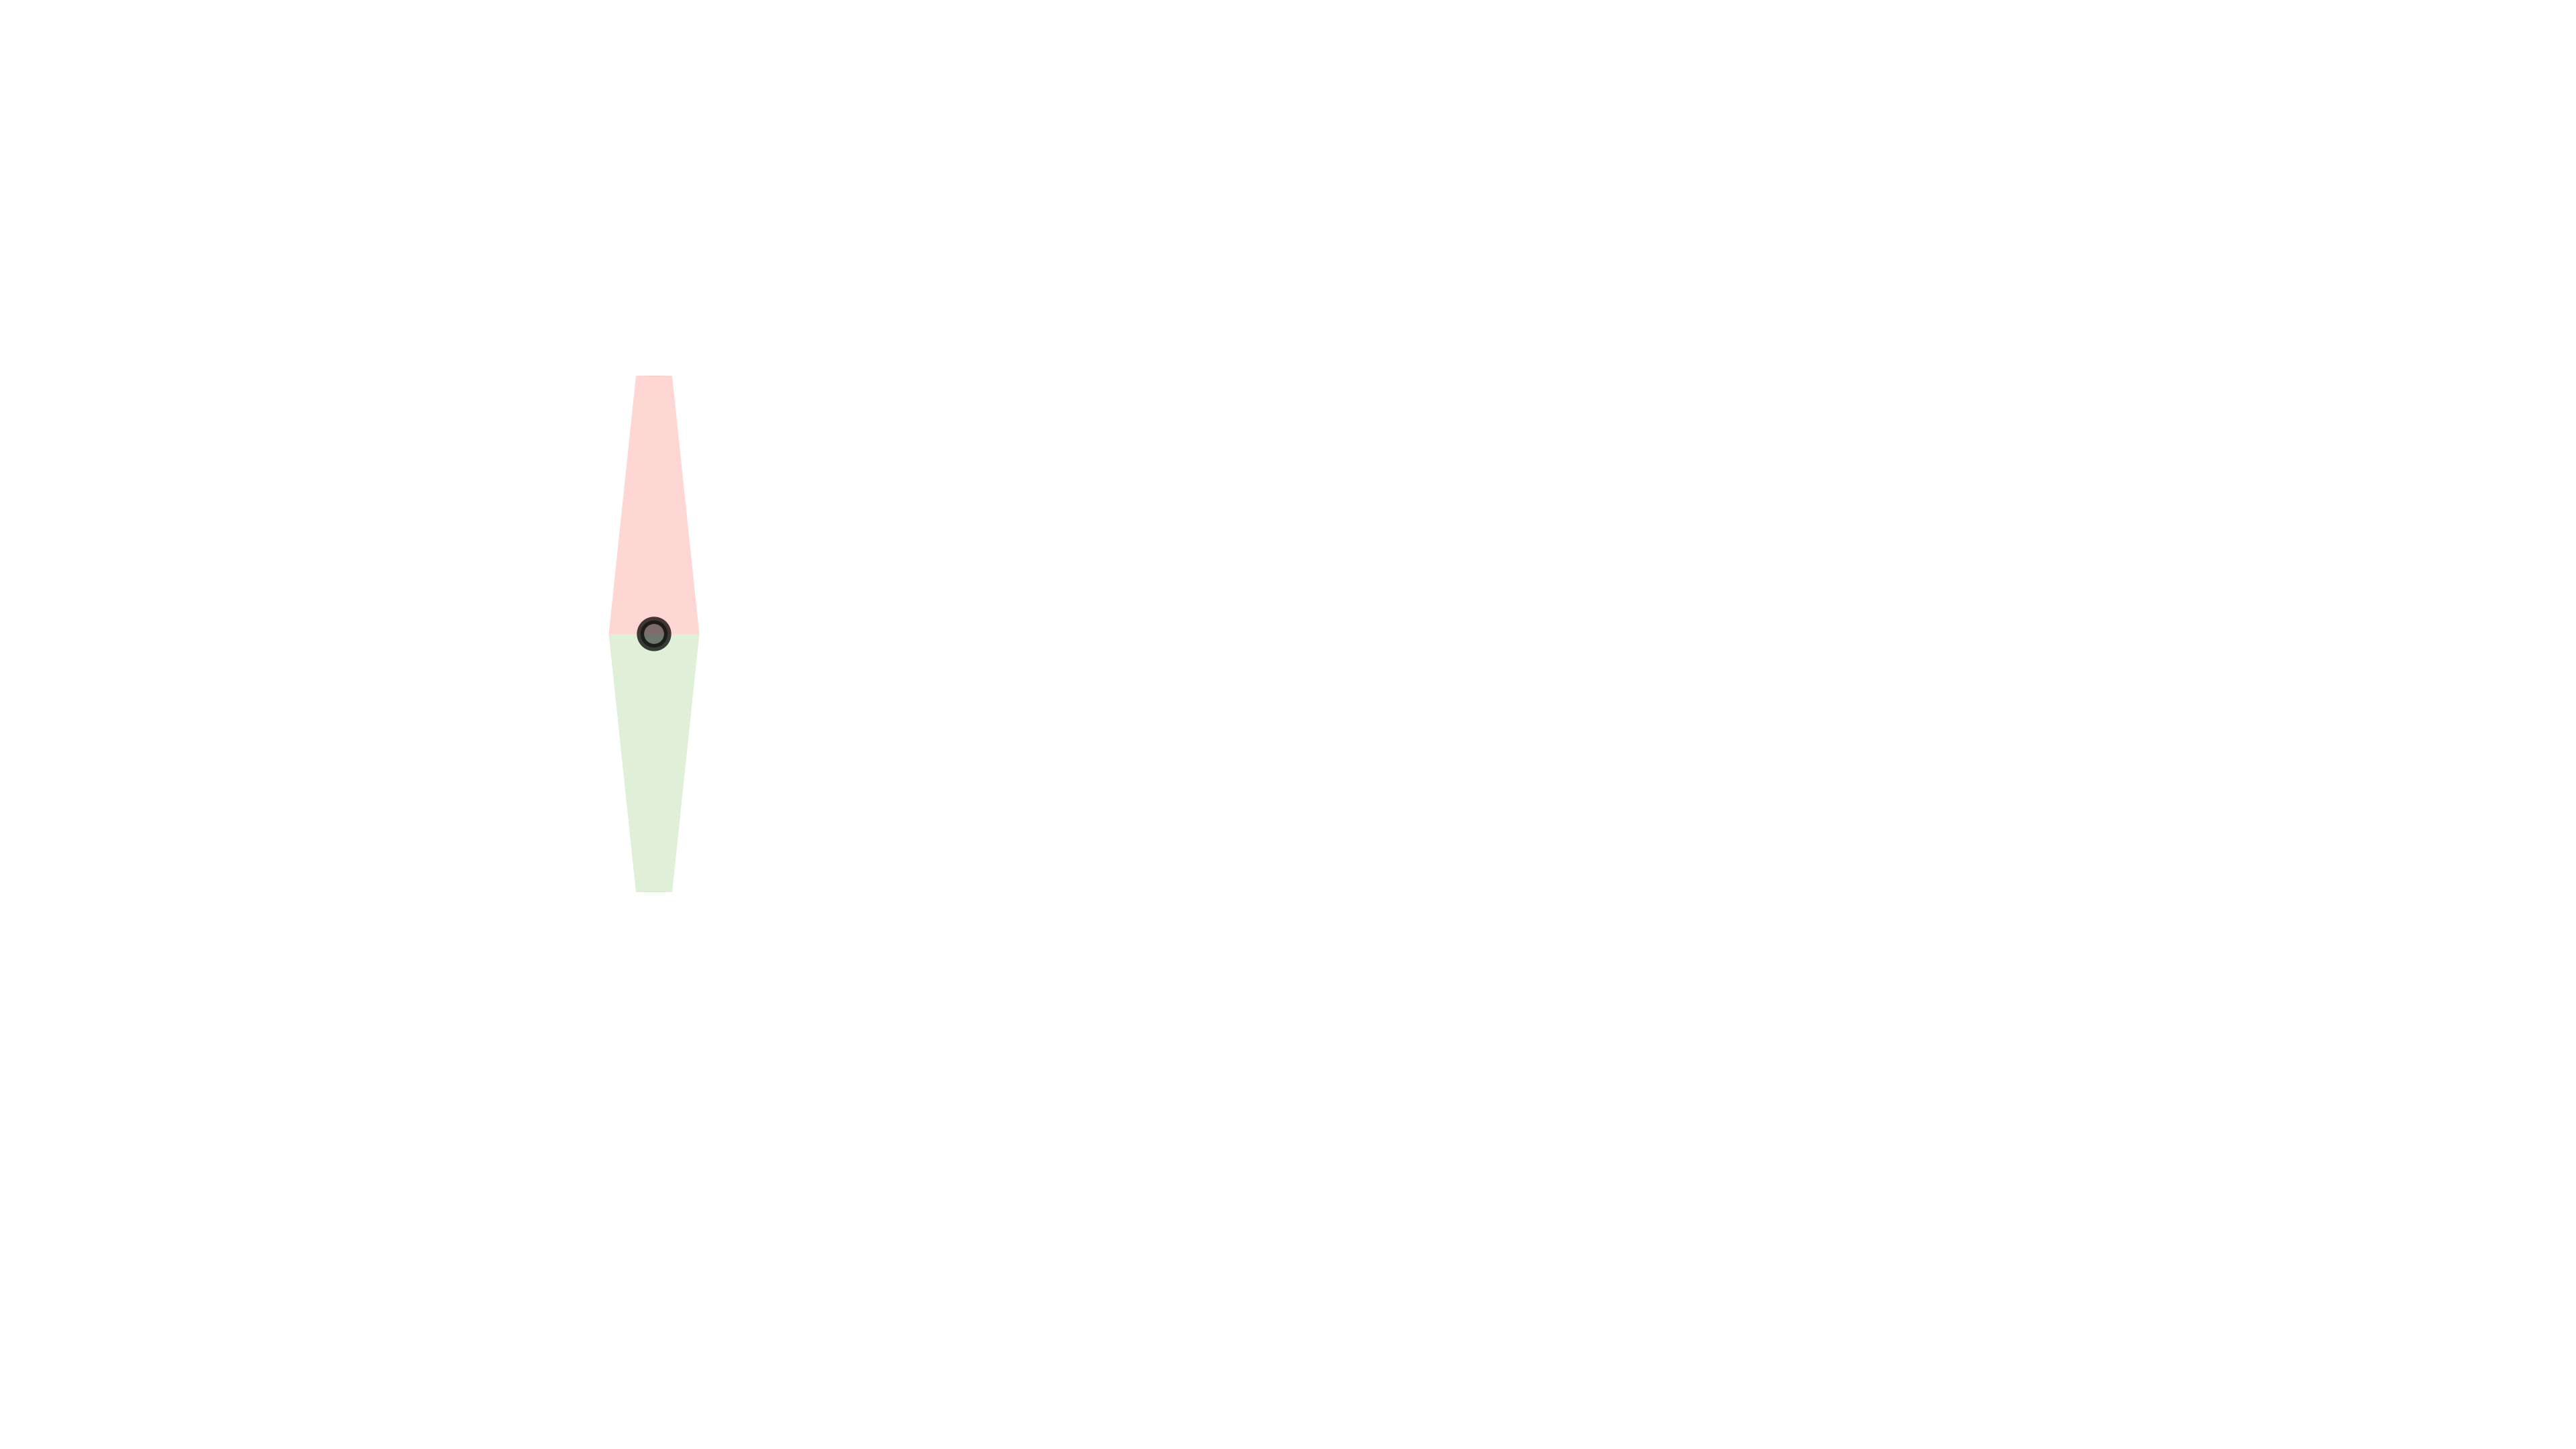

In [27]:
%%manim -qk --fps 60 $video_scene


# images for presentation
class galvani_Scene(ThreeDScene):
    def construct(self):
        self.camera.background_color = WHITE


        # parameters
        compass_centre = np.array([-3.5, 0.5, 0])
        compass_radius = 1.5
        initial_angle = 0

        compass = Compass(centre = compass_centre, radius = compass_radius)
        needle = compass.get_needle(initial_angle)
        poles = compass.get_poles()
        needle.state = np.array([initial_angle, 0.0])
        self.add(needle)


        # coil
        coil_centre = np.array([0, 0.0, 0])
        coil_height = 1.5
        coil_width = 4.5

        coil = Coil(centre = coil_centre, height = coil_height, width = coil_width, n_wind = 16)
        ampere = coil.get_current(0.00)
        # self.add(coil)